# Final Hybrid Model For Single Demand


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
import matplotlib.pyplot as plt
import random
import tensorflow as tf
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


# Load
df = pd.read_csv('energy_iter17.03.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)


In [2]:
# Apply Min-Max scaling
scaler = MinMaxScaler()
features_to_scale = ['Dhaka_Demand', 'Temp(C)', 'humidity', 'feelslike']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])


# Feature Engineering
df['day_of_week'] = df['Date'].dt.dayofweek
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Define Season feature
def get_season(month):
    if month in [12, 11,1,2]:
        return 0  # Winter
    elif month in [3, 4, 5,6,7,8,9,10]:
        return 1  # Summer


df['Season'] = df['Month'].apply(get_season)


In [3]:
# -----------------------------
# Sequence Creation Function
# -----------------------------
def create_sequences(data, demand_seq_len=30, weather_seq_len=5):
    lstm_X, lstm_y, xgb_features, dates = [], [], [], []

    for i in range(demand_seq_len, len(data)):
        if i - weather_seq_len < 0:
            continue

        # Past 30 days of demand
        demand_seq = data[['Dhaka_Demand']].iloc[i - demand_seq_len:i].values

        # Past 5 days of weather data
        weather_features = []
        for j in range(weather_seq_len):
            w = data[['Temp(C)', 'humidity', 'feelslike']].iloc[i - j - 1].values
            weather_features.extend(w)

        # Current day's known calendar features
        time_features = data[['Year', 'Month', 'Season', 'day_of_week', 'IsHoliday']].iloc[i].values

        features = np.concatenate([weather_features, time_features])
        target = data['Dhaka_Demand'].iloc[i]

        lstm_X.append(demand_seq)
        xgb_features.append(features)
        lstm_y.append(target)
        dates.append(data['Date'].iloc[i])

    return np.array(lstm_X), np.array(lstm_y), np.array(xgb_features), np.array(dates)

# -----------------------------
# Create Sequences
# -----------------------------
SEQ_LENGTH = 30
WEATHER_SEQ_LENGTH = 5
lstm_X, lstm_y, xgb_feats, sequence_dates = create_sequences(df, SEQ_LENGTH, WEATHER_SEQ_LENGTH)


In [4]:
# -----------------------------
# Time-Based Train/Validation Split
# -----------------------------
train_end = pd.Timestamp("2024-10-31")
valid_start = pd.Timestamp("2024-11-01")
valid_end = pd.Timestamp("2024-12-31")

train_mask = sequence_dates <= train_end
valid_mask = (sequence_dates >= valid_start) & (sequence_dates <= valid_end)

X_train_lstm, X_valid_lstm = lstm_X[train_mask], lstm_X[valid_mask]
X_train_xgb, X_valid_xgb = xgb_feats[train_mask], xgb_feats[valid_mask]
y_train, y_valid = lstm_y[train_mask], lstm_y[valid_mask]


In [5]:
# -----------------------------
# Train LSTM Model
# -----------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(SEQ_LENGTH, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_split=0.1, verbose=0)

# LSTM Embeddings
lstm_train_embed = lstm_model.predict(X_train_lstm)
lstm_valid_embed = lstm_model.predict(X_valid_lstm)

# -----------------------------
# Train XGBoost on Top of LSTM output + Features
# -----------------------------
X_train_final = np.concatenate([lstm_train_embed, X_train_xgb], axis=1)
X_valid_final = np.concatenate([lstm_valid_embed, X_valid_xgb], axis=1)

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5,random_state=42)
xgb_model.fit(X_train_final, y_train)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

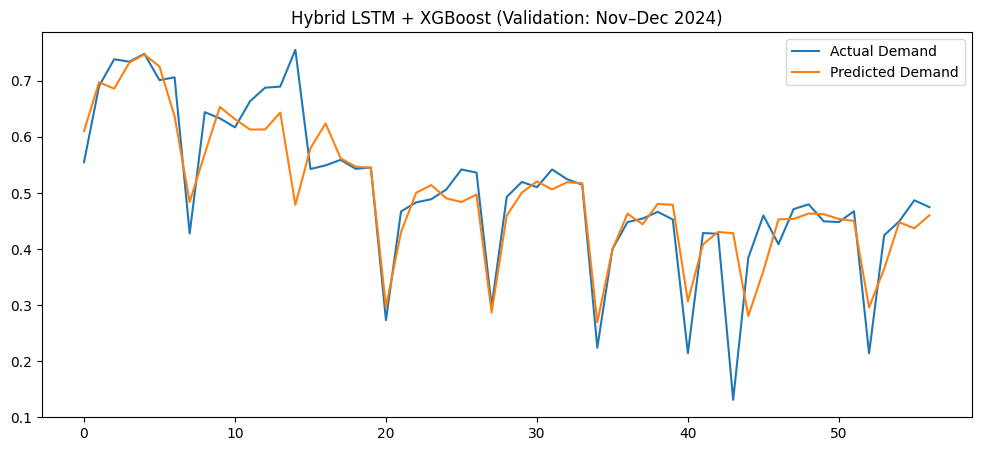

In [6]:
# -----------------------------
# Validate on Nov–Dec 2024
# -----------------------------
y_pred = xgb_model.predict(X_valid_final)

plt.figure(figsize=(12, 5))
plt.plot(y_valid, label='Actual Demand')
plt.plot(y_pred, label='Predicted Demand')
plt.title("Hybrid LSTM + XGBoost (Validation: Nov–Dec 2024)")
plt.legend()
plt.show()

# -----------------------------
# Final Retrain and Predict for 2025-01-01
# -----------------------------
full_mask = sequence_dates <= pd.Timestamp("2024-12-31")
X_full_lstm = lstm_X[full_mask]
X_full_xgb = xgb_feats[full_mask]
y_full = lstm_y[full_mask]


In [7]:

# Retrain LSTM on whole dataset
lstm_model.fit(X_full_lstm, y_full, epochs=10, batch_size=16, verbose=0)
lstm_embed_full = lstm_model.predict(X_full_lstm)

# Retrain XGBoost on whole dataset
X_full_final = np.concatenate([lstm_embed_full, X_full_xgb], axis=1)
xgb_model.fit(X_full_final, y_full)

# -----------------------------
# Predict for 2025-01-01
# -----------------------------
recent_seq = df[['Dhaka_Demand']].iloc[-SEQ_LENGTH:].values.reshape(1, SEQ_LENGTH, 1)

recent_weather = []
for j in range(WEATHER_SEQ_LENGTH):
    w = df[['Temp(C)', 'humidity', 'feelslike']].iloc[-j - 1].values
    recent_weather.extend(w)

# Known calendar values for Jan 1, 2025
future_date = pd.Timestamp("2025-01-01")
future_time = [
    future_date.year,
    future_date.month,
    get_season(future_date.month),
    future_date.dayofweek,
    1  # IsHoliday (manually for Jan 1)
]

final_features = np.concatenate([recent_weather, future_time]).reshape(1, -1)
lstm_embed = lstm_model.predict(recent_seq)
final_input = np.concatenate([lstm_embed, final_features], axis=1)
next_day_pred = xgb_model.predict(final_input)[0]

print(f"✅ Predicted electricity demand for 2025-01-01: {next_day_pred:.2f} MW")



50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
✅ Predicted electricity demand for 2025-01-01: 0.24 MW


In [8]:
# Inverse Scaling transform to get original type demand (MW) value

dummy_input = np.array([[next_day_pred, 0, 0, 0]])
next_day_pred_original = scaler.inverse_transform(dummy_input)[0][0]

print(f"Predicted demand for 2025-01-01: {next_day_pred_original:.2f} MW")


Predicted demand for 2025-01-01: 3105.49 MW


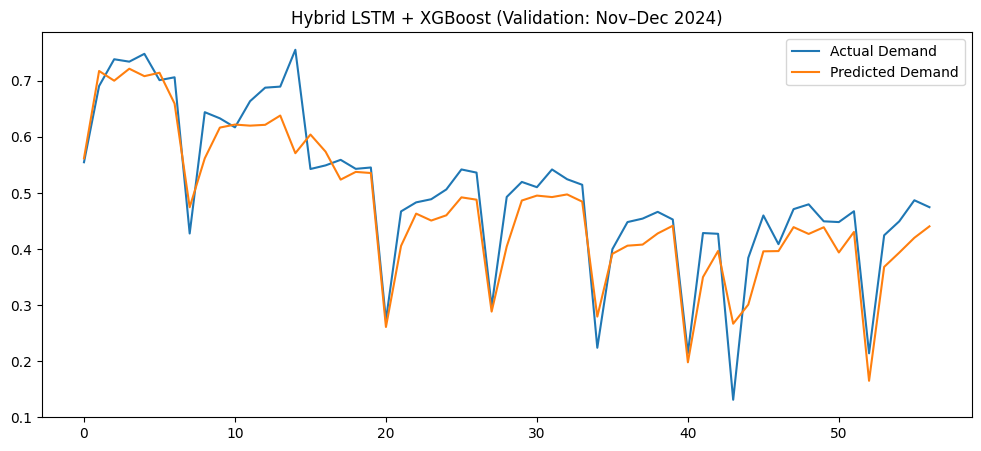

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# -----------------------------
# Validate on Nov–Dec 2024
# -----------------------------


y_pred = xgb_model.predict(X_valid_final)

plt.figure(figsize=(12, 5))
plt.plot(y_valid, label='Actual Demand')
plt.plot(y_pred, label='Predicted Demand')
plt.title("Hybrid LSTM + XGBoost (Validation: Nov–Dec 2024)")
plt.legend()
plt.show()

In [10]:
# -----------------------------
# Model Evaluation
# -----------------------------

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mape = mean_absolute_percentage_error(y_valid, y_pred) * 100
r2 = r2_score(y_valid, y_pred)

print(f" Model Evaluation on Validation Set (Nov–Dec 2024):")
print(f" MAE  : {mae:.2f} MW")
print(f" RMSE : {rmse:.2f} MW")
print(f" MAPE : {mape:.2f}%")
print(f" R²    : {r2:.4f}")

 Model Evaluation on Validation Set (Nov–Dec 2024):
 MAE  : 0.04 MW
 RMSE : 0.05 MW
 MAPE : 10.10%
 R²    : 0.8521


In [11]:
train_pred = xgb_model.predict(X_train_final)

train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
r2 = r2_score(y_train, train_pred)

print(f"\n Training Set Evaluation:")
print(f"MAE  : {train_mae:.2f} MW")
print(f"RMSE : {train_rmse:.2f} MW")
print(f" R²  : {r2:.4f}")



 Training Set Evaluation:
MAE  : 0.04 MW
RMSE : 0.05 MW
 R²  : 0.9247
